## 06 预训练词向量及其应用

### 导入模块并加载数据

In [1]:
from pandas import DataFrame
import torch.nn as nn

from torch.utils.data import DataLoader

from MyModule import (
    load_data, 
    load_vocab, 
    class_weights, 
    train_model_with_validation, 
    test_model_comprehensive, 
    plot_training_curves,
    print_training_summary,
    save_training_results,
    BowDataset
)


train_data = load_data("data/train_tokenized_final.txt", sep=",", is_tokenized=True)
val_data = load_data("data/val_tokenized_final.txt", sep=",", is_tokenized=True)
test_data = load_data("data/test_tokenized_final.txt", sep=",", is_tokenized=True)

# 加载数据
train_dataset = BowDataset(train_data)
val_dataset = BowDataset(val_data)
test_dataset = BowDataset(test_data)

vocab = load_vocab("data/vocab_final.txt")

e:\anaconda3\envs\nlpllma\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 构建预训练词向量矩阵

In [2]:
import numpy as np
import torch

def load_pretrained_embeddings(embedding_path, vocab, embedding_dim=200):
    """根据已有 vocab 构建嵌入矩阵"""
    embeddings = np.random.normal(scale=0.6, size=(len(vocab), embedding_dim))  # 随机初始化
    with open(embedding_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype='float32')
            if word in vocab.token_to_idx:
                embeddings[vocab[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float32)

embedding_matrix = load_pretrained_embeddings("resources/Word2Vec-100000-small.txt", vocab, embedding_dim=200)

### 多层感知机

In [3]:
from MyModule import MLP, collate_fn_mlp

# 超参数设置
embedding_dim = 200
num_class = 3
hidden_dim = 256
batch_size = 32
num_epoch = 10


train_data_loader_mlp = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=True)
val_data_loader_mlp = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=False)
test_data_loader_mlp = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_mlp, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_pre_emb = MLP(len(vocab), embedding_dim, hidden_dim, num_class, 
                  embedding_matrix.clone().detach(), freeze=False)
mlp_pre_emb.to(device)

MLP(
  (embeddingbag): EmbeddingBag(35272, 200, mode='mean')
  (linear1): Linear(in_features=200, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [4]:
# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(mlp_pre_emb.parameters(), lr=0.001)

mlp_history = train_model_with_validation(
    model=mlp_pre_emb,
    train_loader=train_data_loader_mlp,
    val_loader=val_data_loader_mlp,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)


Training Epoch 1: 100%|██████████| 8532/8532 [00:34<00:00, 249.73it/s]


Epoch 1/10
    Train Loss: 0.6461	Train Accuracy: 0.7104
    Valid Loss: 0.5918	Valid Accuracy: 0.7360
    Valid Precision: 0.7369	Valid Recall: 0.7360	Valid F1: 0.7316
    ✓ New best validation loss: 0.5918
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8532/8532 [00:34<00:00, 245.85it/s]


Epoch 2/10
    Train Loss: 0.5446	Train Accuracy: 0.7633
    Valid Loss: 0.5801	Valid Accuracy: 0.7471
    Valid Precision: 0.7466	Valid Recall: 0.7471	Valid F1: 0.7428
    ✓ New best validation loss: 0.5801
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8532/8532 [00:34<00:00, 247.51it/s]


Epoch 3/10
    Train Loss: 0.4952	Train Accuracy: 0.7867
    Valid Loss: 0.5863	Valid Accuracy: 0.7444
    Valid Precision: 0.7466	Valid Recall: 0.7444	Valid F1: 0.7398
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8532/8532 [00:34<00:00, 248.60it/s]


Epoch 4/10
    Train Loss: 0.4566	Train Accuracy: 0.8045
    Valid Loss: 0.5983	Valid Accuracy: 0.7490
    Valid Precision: 0.7480	Valid Recall: 0.7490	Valid F1: 0.7447
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8532/8532 [00:34<00:00, 248.50it/s]


Epoch 5/10
    Train Loss: 0.4226	Train Accuracy: 0.8213
    Valid Loss: 0.6223	Valid Accuracy: 0.7497
    Valid Precision: 0.7492	Valid Recall: 0.7497	Valid F1: 0.7478
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5801


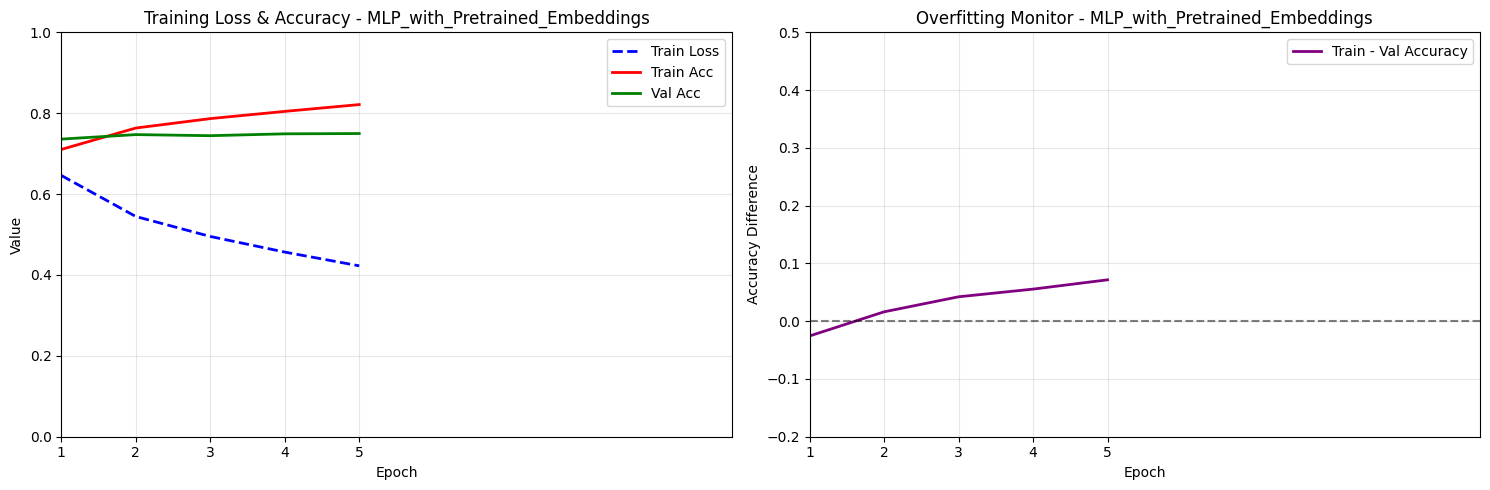


TRAINING SUMMARY
Model Name: MLP_with_Pretrained_Embeddings
Final Train Loss: 0.4226
Final Train Accuracy: 0.8213
Final Val Loss: 0.6223
Final Val Accuracy: 0.7497
Best Val Accuracy: 0.7497 (Epoch 5)
Final Overfitting Gap: 0.0716


In [5]:
# 绘制训练曲线
plot_training_curves("MLP_with_Pretrained_Embeddings", mlp_history)

# 打印训练摘要
print_training_summary("MLP_with_Pretrained_Embeddings", mlp_history)

Testing: 100%|██████████| 58497/58497 [00:44<00:00, 1307.33it/s]



TEST RESULTS
Model Name: MLP_with_pretrained_embeddings
Test Accuracy: 0.7441
Test Precision (weighted): 0.7431
Test Recall (weighted): 0.7441
Test F1 Score (weighted): 0.7397

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7894    0.7349    0.7612     18605
     Neutral     0.6937    0.5631    0.6216     14749
    Positive     0.7379    0.8571    0.7931     25143

    accuracy                         0.7441     58497
   macro avg     0.7403    0.7184    0.7253     58497
weighted avg     0.7431    0.7441    0.7397     58497



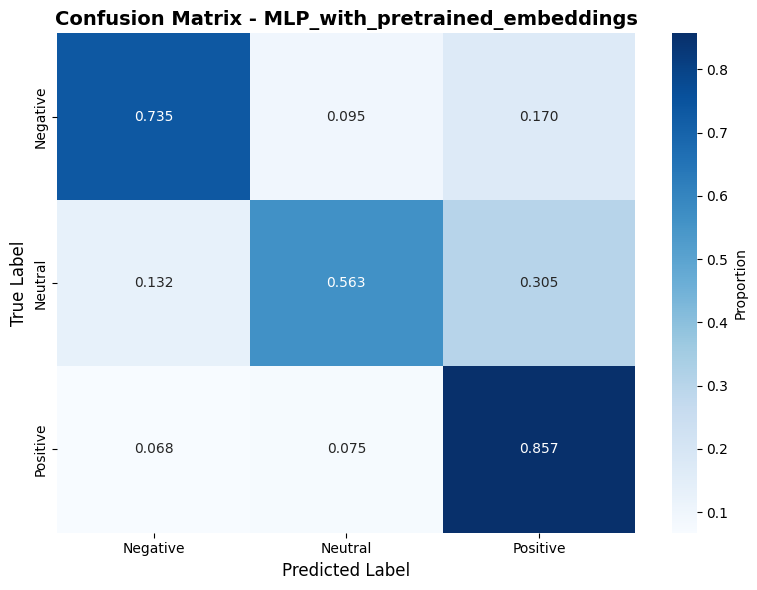


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7894, Recall=0.7349, F1=0.7612, Support=18605
 Neutral: Precision=0.6937, Recall=0.5631, F1=0.6216, Support=14749
Positive: Precision=0.7379, Recall=0.8571, F1=0.7931, Support=25143


In [6]:
mlp_test_results = test_model_comprehensive(
    model=mlp_pre_emb,
    model_name="MLP_with_pretrained_embeddings",
    test_loader=test_data_loader_mlp,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive']
)

In [7]:
# 保存MLP训练结果
save_training_results(
    model=mlp_pre_emb,
    model_name="MLP with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(mlp_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=mlp_history,
    test_results=mlp_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: MLP with Pretrained Embeddings (MLP)
  - 实际训练轮数: 5
  - 测试准确率: 0.7441
  - 测试F1分数: 0.7397
  - 记录时间: 2025-11-17 19:20:19
  - 总记录数: 27


### 卷积神经网络

In [8]:
from MyModule import CNN, collate_fn_cnn

train_data_loader_cnn = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=True)
val_data_loader_cnn = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=False)
test_data_loader_cnn = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_cnn, shuffle=False)

# CNN 相关参数
filter_size = 3
num_filter = 100

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_pre_emb = CNN(len(vocab), embedding_dim, filter_size, num_filter, num_class, 
                  embedding_matrix.clone().detach(), freeze=False)
cnn_pre_emb.to(device)

CNN(
  (embedding): Embedding(35272, 200)
  (conv1d): Conv1d(200, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=100, out_features=3, bias=True)
)

In [9]:
# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(cnn_pre_emb.parameters(), lr=0.001)

cnn_history = train_model_with_validation(
    model=cnn_pre_emb,
    train_loader=train_data_loader_cnn,
    val_loader=val_data_loader_cnn,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 8532/8532 [00:36<00:00, 234.72it/s]


Epoch 1/10
    Train Loss: 0.6113	Train Accuracy: 0.7241
    Valid Loss: 0.6046	Valid Accuracy: 0.7533
    Valid Precision: 0.7505	Valid Recall: 0.7533	Valid F1: 0.7477
    ✓ New best validation loss: 0.6046
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8532/8532 [00:37<00:00, 229.21it/s]


Epoch 2/10
    Train Loss: 0.5202	Train Accuracy: 0.7745
    Valid Loss: 0.5913	Valid Accuracy: 0.7589
    Valid Precision: 0.7565	Valid Recall: 0.7589	Valid F1: 0.7566
    ✓ New best validation loss: 0.5913
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8532/8532 [00:36<00:00, 235.23it/s]


Epoch 3/10
    Train Loss: 0.4705	Train Accuracy: 0.7990
    Valid Loss: 0.5720	Valid Accuracy: 0.7407
    Valid Precision: 0.7508	Valid Recall: 0.7407	Valid F1: 0.7365
    ✓ New best validation loss: 0.5720
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8532/8532 [00:36<00:00, 235.24it/s]


Epoch 4/10
    Train Loss: 0.4316	Train Accuracy: 0.8179
    Valid Loss: 0.5662	Valid Accuracy: 0.7552
    Valid Precision: 0.7557	Valid Recall: 0.7552	Valid F1: 0.7530
    ✓ New best validation loss: 0.5662
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8532/8532 [00:36<00:00, 235.85it/s]


Epoch 5/10
    Train Loss: 0.3963	Train Accuracy: 0.8345
    Valid Loss: 0.5977	Valid Accuracy: 0.7449
    Valid Precision: 0.7545	Valid Recall: 0.7449	Valid F1: 0.7476
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 8532/8532 [00:36<00:00, 236.35it/s]


Epoch 6/10
    Train Loss: 0.3653	Train Accuracy: 0.8490
    Valid Loss: 0.6005	Valid Accuracy: 0.7527
    Valid Precision: 0.7506	Valid Recall: 0.7527	Valid F1: 0.7513
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 8532/8532 [00:36<00:00, 236.28it/s]


Epoch 7/10
    Train Loss: 0.3394	Train Accuracy: 0.8599
    Valid Loss: 0.6266	Valid Accuracy: 0.7417
    Valid Precision: 0.7486	Valid Recall: 0.7417	Valid F1: 0.7427
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5662


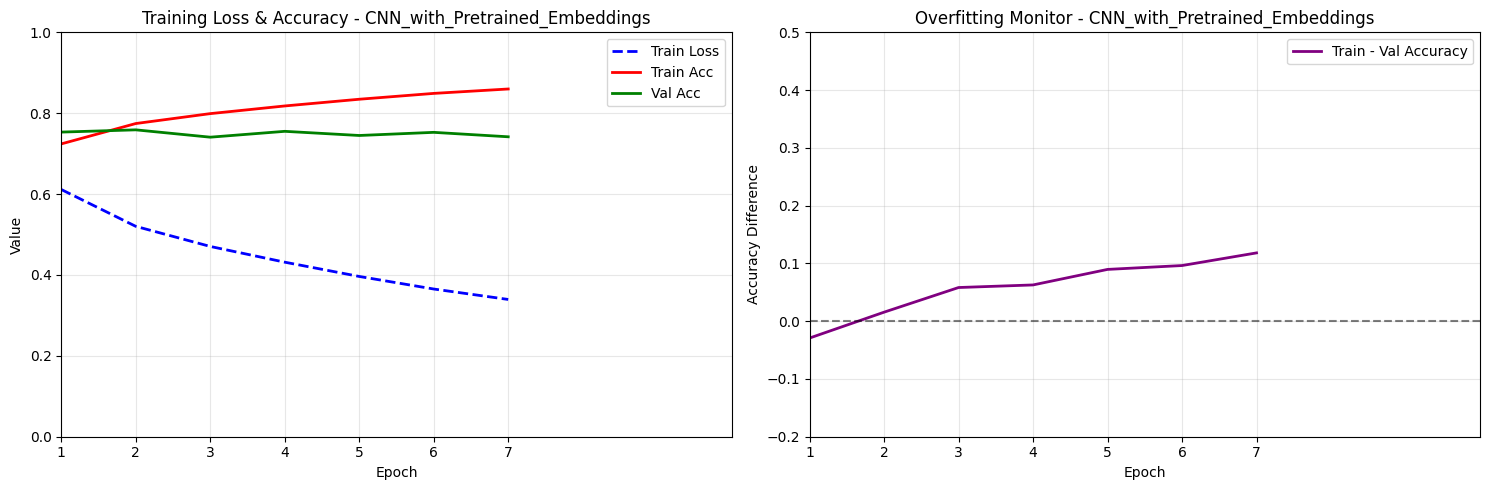


TRAINING SUMMARY
Model Name: CNN_with_Pretrained_Embeddings
Final Train Loss: 0.3394
Final Train Accuracy: 0.8599
Final Val Loss: 0.6266
Final Val Accuracy: 0.7417
Best Val Accuracy: 0.7589 (Epoch 2)
Final Overfitting Gap: 0.1182


In [10]:
# 绘制训练曲线
plot_training_curves("CNN_with_Pretrained_Embeddings", cnn_history)

# 打印训练摘要
print_training_summary("CNN_with_Pretrained_Embeddings", cnn_history)

Testing: 100%|██████████| 58497/58497 [00:58<00:00, 1007.78it/s]



TEST RESULTS
Model Name: CNN with Pretrained Embeddings
Test Accuracy: 0.7492
Test Precision (weighted): 0.7471
Test Recall (weighted): 0.7492
Test F1 Score (weighted): 0.7453

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7967    0.7477    0.7714     18605
     Neutral     0.6775    0.5711    0.6197     14749
    Positive     0.7514    0.8548    0.7997     25143

    accuracy                         0.7492     58497
   macro avg     0.7418    0.7245    0.7303     58497
weighted avg     0.7471    0.7492    0.7453     58497



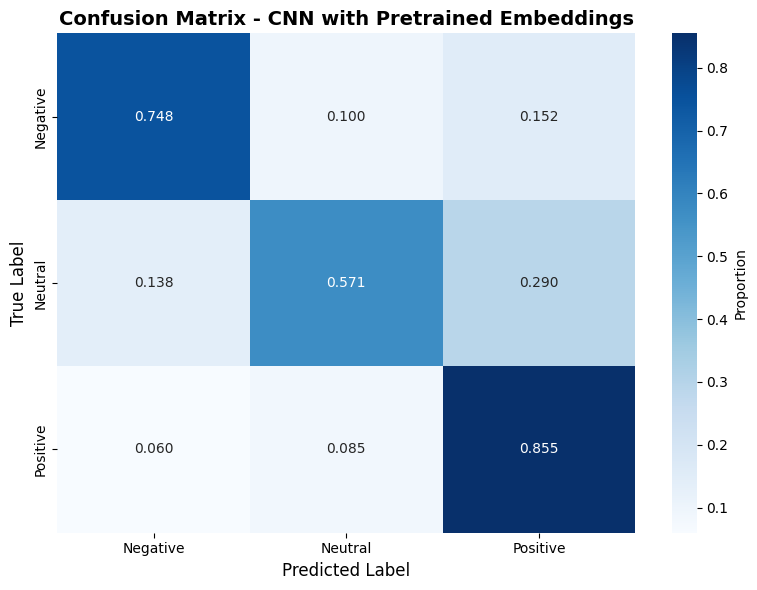


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7967, Recall=0.7477, F1=0.7714, Support=18605
 Neutral: Precision=0.6775, Recall=0.5711, F1=0.6197, Support=14749
Positive: Precision=0.7514, Recall=0.8548, F1=0.7997, Support=25143


In [11]:
# CNN 测试过程 - 使用通用框架
cnn_test_results = test_model_comprehensive(
    model=cnn_pre_emb,
    model_name="CNN with Pretrained Embeddings",
    test_loader=test_data_loader_cnn,
    device=device
)

In [12]:
# 保存CNN训练结果
save_training_results(
    model=cnn_pre_emb,
    model_name="CNN with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(cnn_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=cnn_history,
    test_results=cnn_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: CNN with Pretrained Embeddings (CNN)
  - 实际训练轮数: 7
  - 测试准确率: 0.7492
  - 测试F1分数: 0.7453
  - 记录时间: 2025-11-17 19:25:56
  - 总记录数: 28


### 长短期记忆网络

In [13]:
from MyModule import LSTM, collate_fn_lstm

train_data_loader_lstm = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=True)
val_data_loader_lstm = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=False)
test_data_loader_lstm = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_lstm, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_pre_emb = LSTM(len(vocab), embedding_dim, hidden_dim, num_class, 
                    embedding_matrix.clone().detach(), freeze=False)
lstm_pre_emb.to(device)

LSTM(
  (embeddings): Embedding(35272, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=256, out_features=3, bias=True)
)

In [14]:
# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(lstm_pre_emb.parameters(), lr=0.001)

lstm_history = train_model_with_validation(
    model=lstm_pre_emb,
    train_loader=train_data_loader_lstm,
    val_loader=val_data_loader_lstm,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
    )

Training Epoch 1: 100%|██████████| 8532/8532 [00:56<00:00, 150.15it/s]


Epoch 1/10
    Train Loss: 0.6010	Train Accuracy: 0.7317
    Valid Loss: 0.5451	Valid Accuracy: 0.7589
    Valid Precision: 0.7655	Valid Recall: 0.7589	Valid F1: 0.7602
    ✓ New best validation loss: 0.5451
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8532/8532 [00:55<00:00, 153.41it/s]


Epoch 2/10
    Train Loss: 0.4813	Train Accuracy: 0.7925
    Valid Loss: 0.5278	Valid Accuracy: 0.7653
    Valid Precision: 0.7712	Valid Recall: 0.7653	Valid F1: 0.7661
    ✓ New best validation loss: 0.5278
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8532/8532 [00:55<00:00, 154.36it/s]


Epoch 3/10
    Train Loss: 0.4055	Train Accuracy: 0.8280
    Valid Loss: 0.5563	Valid Accuracy: 0.7670
    Valid Precision: 0.7679	Valid Recall: 0.7670	Valid F1: 0.7662
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8532/8532 [00:55<00:00, 154.08it/s]


Epoch 4/10
    Train Loss: 0.3327	Train Accuracy: 0.8602
    Valid Loss: 0.5930	Valid Accuracy: 0.7633
    Valid Precision: 0.7634	Valid Recall: 0.7633	Valid F1: 0.7626
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8532/8532 [00:55<00:00, 153.68it/s]


Epoch 5/10
    Train Loss: 0.2662	Train Accuracy: 0.8892
    Valid Loss: 0.6774	Valid Accuracy: 0.7599
    Valid Precision: 0.7603	Valid Recall: 0.7599	Valid F1: 0.7583
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5278


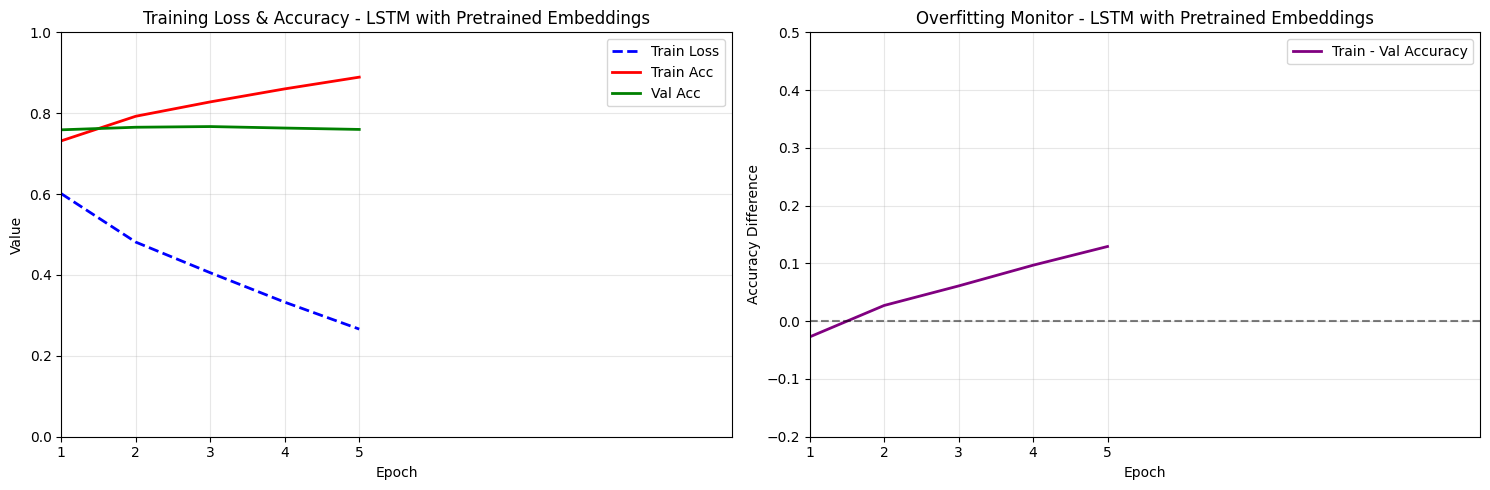


TRAINING SUMMARY
Model Name: LSTM with Pretrained Embeddings
Final Train Loss: 0.2662
Final Train Accuracy: 0.8892
Final Val Loss: 0.6774
Final Val Accuracy: 0.7599
Best Val Accuracy: 0.7670 (Epoch 3)
Final Overfitting Gap: 0.1293


In [15]:
# 绘制训练曲线
plot_training_curves("LSTM with Pretrained Embeddings", lstm_history)

# 打印训练摘要
print_training_summary("LSTM with Pretrained Embeddings", lstm_history)

Testing: 100%|██████████| 58497/58497 [01:11<00:00, 816.77it/s]



TEST RESULTS
Model Name: LSTM with Pretrained Embeddings
Test Accuracy: 0.7618
Test Precision (weighted): 0.7678
Test Recall (weighted): 0.7618
Test F1 Score (weighted): 0.7627

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8439    0.7200    0.7770     18605
     Neutral     0.6342    0.6916    0.6617     14749
    Positive     0.7899    0.8339    0.8113     25143

    accuracy                         0.7618     58497
   macro avg     0.7560    0.7485    0.7500     58497
weighted avg     0.7678    0.7618    0.7627     58497



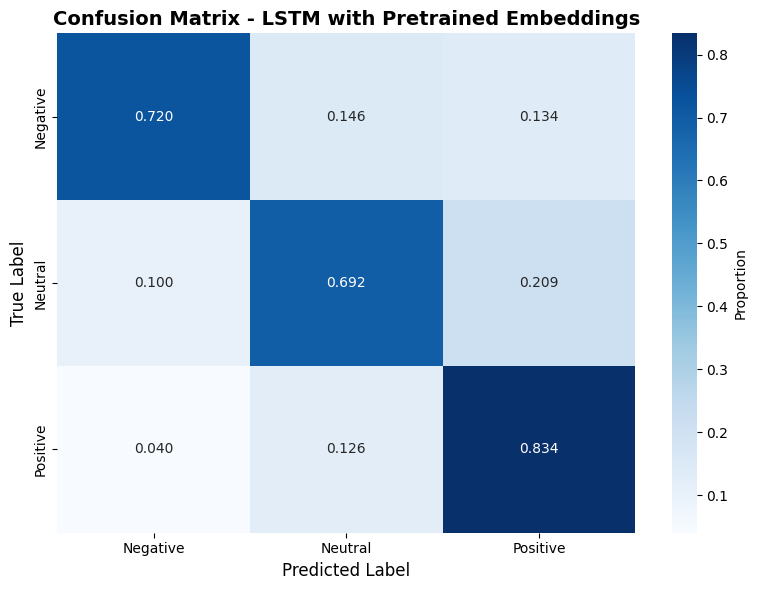


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8439, Recall=0.7200, F1=0.7770, Support=18605
 Neutral: Precision=0.6342, Recall=0.6916, F1=0.6617, Support=14749
Positive: Precision=0.7899, Recall=0.8339, F1=0.8113, Support=25143


In [16]:
# LSTM 测试过程 - 使用通用框架
lstm_test_results = test_model_comprehensive(
    model=lstm_pre_emb,
    model_name="LSTM with Pretrained Embeddings", 
    test_loader=test_data_loader_lstm,
    device=device
)

In [17]:
# 保存LSTM训练结果
save_training_results(
    model=lstm_pre_emb,
    model_name="LSTM with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(lstm_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=lstm_history,
    test_results=lstm_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: LSTM with Pretrained Embeddings (LSTM)
  - 实际训练轮数: 5
  - 测试准确率: 0.7618
  - 测试F1分数: 0.7627
  - 记录时间: 2025-11-17 19:32:12
  - 总记录数: 29


### Transformer

In [18]:
from MyModule import Transformer, collate_fn_trans

train_data_loader_trans = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=True)
val_data_loader_trans = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=False)
test_data_loader_trans = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_trans, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer_pre_emb = Transformer(len(vocab), embedding_dim, num_class, 
                                  pretrained_embedding_matrix=embedding_matrix.clone().detach(), 
                                  freeze=False)
transformer_pre_emb.to(device)

e:\anaconda3\envs\nlpllma\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer(
  (embeddings): Embedding(35272, 200)
  (position_embedding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output): Linear(in_features=200, out_features=3, bias=True)
)

In [19]:

# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(transformer_pre_emb.parameters(), lr=0.001)

transformer_history = train_model_with_validation(
    model=transformer_pre_emb,
    train_loader=train_data_loader_trans,
    val_loader=val_data_loader_trans,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 8532/8532 [01:02<00:00, 135.88it/s]


Epoch 1/10
    Train Loss: 0.7277	Train Accuracy: 0.6680
    Valid Loss: 0.6902	Valid Accuracy: 0.7072
    Valid Precision: 0.7036	Valid Recall: 0.7072	Valid F1: 0.7026
    ✓ New best validation loss: 0.6902
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8532/8532 [01:01<00:00, 139.81it/s]


Epoch 2/10
    Train Loss: 0.6981	Train Accuracy: 0.6905
    Valid Loss: 0.6777	Valid Accuracy: 0.7000
    Valid Precision: 0.6978	Valid Recall: 0.7000	Valid F1: 0.6965
    ✓ New best validation loss: 0.6777
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8532/8532 [01:01<00:00, 139.43it/s]


Epoch 3/10
    Train Loss: 0.6635	Train Accuracy: 0.7082
    Valid Loss: 0.6760	Valid Accuracy: 0.6949
    Valid Precision: 0.6963	Valid Recall: 0.6949	Valid F1: 0.6893
    ✓ New best validation loss: 0.6760
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8532/8532 [01:00<00:00, 139.94it/s]


Epoch 4/10
    Train Loss: 0.6509	Train Accuracy: 0.7132
    Valid Loss: 0.6979	Valid Accuracy: 0.6824
    Valid Precision: 0.6829	Valid Recall: 0.6824	Valid F1: 0.6730
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8532/8532 [01:37<00:00, 87.77it/s] 


Epoch 5/10
    Train Loss: 0.6735	Train Accuracy: 0.7012
    Valid Loss: 0.6983	Valid Accuracy: 0.7074
    Valid Precision: 0.7051	Valid Recall: 0.7074	Valid F1: 0.7001
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 8532/8532 [01:29<00:00, 95.50it/s] 


Epoch 6/10
    Train Loss: 0.6456	Train Accuracy: 0.7217
    Valid Loss: 0.7094	Valid Accuracy: 0.6933
    Valid Precision: 0.6910	Valid Recall: 0.6933	Valid F1: 0.6862
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.6760


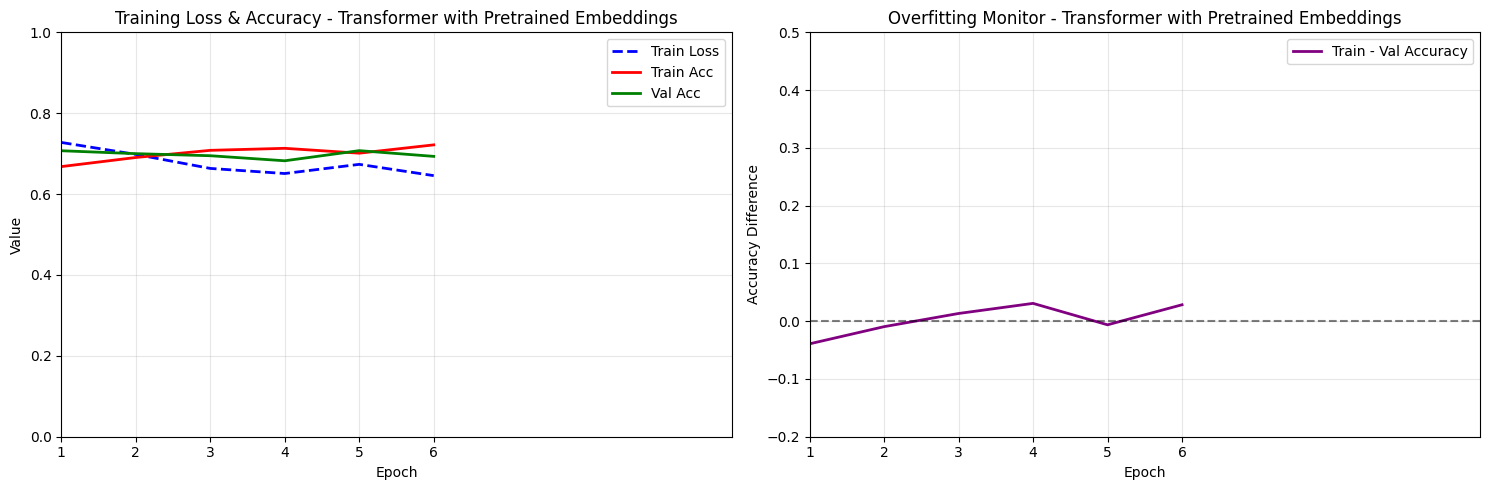


TRAINING SUMMARY
Model Name: Transformer with Pretrained Embeddings with Pretrained Embeddings
Final Train Loss: 0.6456
Final Train Accuracy: 0.7217
Final Val Loss: 0.7094
Final Val Accuracy: 0.6933
Best Val Accuracy: 0.7074 (Epoch 5)
Final Overfitting Gap: 0.0284


In [20]:
# 绘制训练曲线
plot_training_curves("Transformer with Pretrained Embeddings", transformer_history)

# 打印训练摘要
print_training_summary("Transformer with Pretrained Embeddings with Pretrained Embeddings", transformer_history)

Testing: 100%|██████████| 58497/58497 [01:52<00:00, 519.61it/s]



TEST RESULTS
Model Name: Transformer with Pretrained Embeddings
Test Accuracy: 0.6921
Test Precision (weighted): 0.6926
Test Recall (weighted): 0.6921
Test F1 Score (weighted): 0.6867

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7561    0.6311    0.6879     18605
     Neutral     0.6138    0.5235    0.5651     14749
    Positive     0.6919    0.8362    0.7572     25143

    accuracy                         0.6921     58497
   macro avg     0.6872    0.6636    0.6701     58497
weighted avg     0.6926    0.6921    0.6867     58497



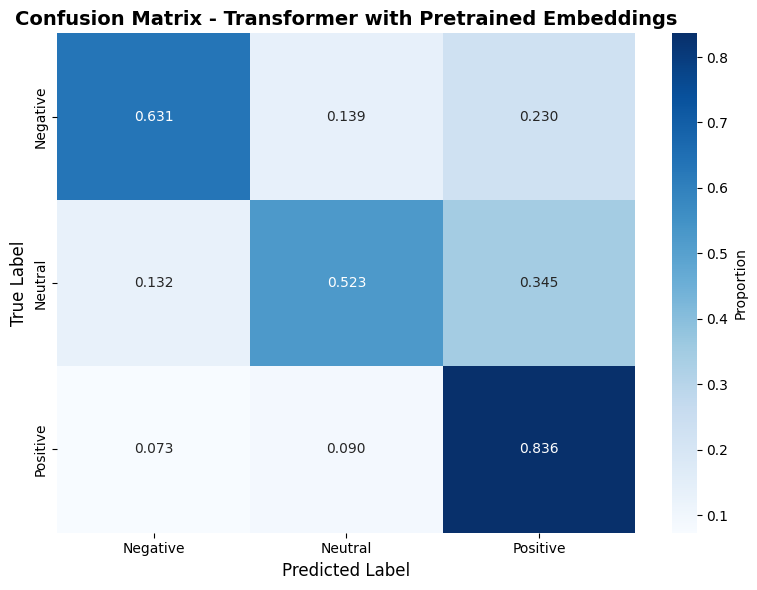


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7561, Recall=0.6311, F1=0.6879, Support=18605
 Neutral: Precision=0.6138, Recall=0.5235, F1=0.5651, Support=14749
Positive: Precision=0.6919, Recall=0.8362, F1=0.7572, Support=25143


In [21]:
# Transformer 测试过程 - 使用通用框架
transformer_test_results = test_model_comprehensive(
    model=transformer_pre_emb,
    model_name="Transformer with Pretrained Embeddings",
    test_loader=test_data_loader_trans,
    device=device
)

In [22]:
# 保存Transformer训练结果
save_training_results(
    model=transformer_pre_emb,
    model_name="Transformer with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(transformer_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=transformer_history,
    test_results=transformer_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: Transformer with Pretrained Embeddings (Transformer)
  - 实际训练轮数: 6
  - 测试准确率: 0.6921
  - 测试F1分数: 0.6867
  - 记录时间: 2025-11-17 19:41:59
  - 总记录数: 30
